In [1]:
from datetime import datetime
import tensorflow as tf
import importlib
import numpy as np
import pandas as pd
from datetime import datetime
now = str(datetime.now().date())

In [2]:
# import config 
import configs.config
importlib.reload(configs.config)
from configs.config import CFG
from utils import config
config = config.Config.from_json(CFG)

## Create Dataset

In [3]:
#window_size = int(config.data.test_slice_length*3600/config.data.record_interval)
window_size = int(config.data.test_slice_length*3600/config.data.record_interval/5)

# define train
epochs = config.train.epoches
batch_size = config.train.batch_size
stride = config.train.stride

shuffle_buffer_size = config.train.shuffle_buffer_size

#define model
num_classes = config.model.output

In [4]:
# create Train Series and Dataset 
import dataloader.dataloader
importlib.reload(dataloader.dataloader)
from dataloader.dataloader import Train_Series
try: 
    del series
except:
    pass
from dataloader.dataloader import Test_Series
try: 
    del test_series
except:
    pass

series = Train_Series(config.data,config.paths)
series.createSeries()
test_series = Test_Series(config.data,config.paths)
test_series.createSeries()



In [10]:
ds.train

array([[[-1.80942722e+00,  2.05823728e-01,  4.51460392e-01,
         -1.81107897e+00, -5.06344762e-01,  0.00000000e+00],
        [-1.81265307e+00,  2.15039716e-01,  4.52853788e-01,
         -1.84450704e+00,  2.56317835e-01,  0.00000000e+00],
        [-1.77189673e+00,  2.24255703e-01,  4.19412278e-01,
         -1.85582360e+00,  3.21264689e-01,  0.00000000e+00],
        ...,
        [-3.73769110e-01,  6.91199086e-01,  2.81923877e+00,
         -2.31413167e-01, -9.53421961e-01,  0.00000000e+00],
        [-1.08964461e-01,  0.00000000e+00,  2.55329914e+00,
         -2.05559942e-01, -3.35391045e-01,  0.00000000e+00],
        [ 7.85692990e-04,  3.37919553e-02,  2.25949158e+00,
         -1.81627410e-01, -7.20610474e-01,  0.00000000e+00]],

       [[-9.58692617e-01,  7.57246998e-01,  1.90815666e+00,
         -2.95059213e-01, -1.74713323e+00,  0.00000000e+00],
        [-9.95444534e-01,  9.83038700e-02,  1.58230099e+00,
         -3.04005584e-01, -1.98248419e+00,  0.00000000e+00],
        [-7.82346

In [16]:

import dataloader.dataloader
importlib.reload(dataloader.dataloader)
try: 
    del ds, Dataset
except:
    pass
from dataloader.dataloader import Dataset

ds = Dataset(series,test_series)
ds.split_dataset(window=True)



In [150]:
def windowed_dataset(series,  window_size, stride, batch_size, shuffle_buffer,drop_remainder = True):
        """Generates dataset windows

        Args:
        series (array of float) - contains the values of the time series
        labels - contains 
        window_size (int) - the number of time steps to average
        batch_size (int) - the batch size
        shuffle_buffer(int) - buffer size to use for the shuffle method

        Returns:
        dataset (TF Dataset) - TF Dataset containing time windows
        """
        num_classes = np.max(series[:,:,-1])+1
        dataset = series.reshape(-1,series.shape[-1])
        # Generate a TF Dataset from the series values
        dataset = tf.data.Dataset.from_tensor_slices(dataset)

        # Window the data but only take those with the specified size
        #dataset = dataset.window(window_size, shift=stride, drop_remainder=drop_remainder)
        dataset = dataset.window(window_size+1, shift=stride, drop_remainder=drop_remainder)

        # Flatten the windows by putting its elements in a single batch
        dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

        #
        # Create tuples with features and labels 
        #dataset = dataset.map(lambda window: (window[:,:-1], tf.one_hot(tf.dtypes.cast(window[:,-1],tf.int8),depth=num_classes)))
        dataset = dataset.map(lambda window: (window[:-1,:-1], tf.one_hot(tf.dtypes.cast(window[-1,-1],tf.int8),depth=num_classes)))
        #dataset = dataset.map(lambda window: (window[:,:-1], window[:,-1]))

        # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer)

        # Create batches of windows
        dataset = dataset.batch(batch_size).prefetch(1)

        return dataset

In [151]:
window_size 

30

In [152]:

dataset = windowed_dataset(ds.train, 10, 1, batch_size,shuffle_buffer_size)
num_features = dataset.element_spec[0].shape[-1]

In [153]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [124]:

random_indices = np.random.randint(0,batch_size,batch_size//10)
indices = np.zeros(batch_size,dtype=bool)
for i in random_indices:
    indices[i] = True
#tune_dataset = dataset.map(lambda x,y : (x[indices],y[indices]))
tune_dataset = dataset.map(lambda x,y : (tf.gather(x,random_indices,axis = 0),tf.gather(y,random_indices,axis = 0)))
# Flatten the windows by putting its elements in a single batch
# tune_dataset = tune_dataset.batch(batch_size)
for window in tune_dataset:
    # if window.shape != (batch_size,window_size,window.shape[-1]):
    #     print(window)
    #     break
    print(window)
    break

(<tf.Tensor: shape=(6, 10, 5), dtype=float64, numpy=
array([[[ 1.65809230e+00,  0.00000000e+00,  0.00000000e+00,
          1.74922766e+00,  0.00000000e+00],
        [ 1.65809230e+00,  0.00000000e+00,  0.00000000e+00,
          1.74922766e+00,  0.00000000e+00],
        [ 1.65809230e+00,  0.00000000e+00,  0.00000000e+00,
          1.74922766e+00,  0.00000000e+00],
        [ 1.65809230e+00,  0.00000000e+00,  0.00000000e+00,
          1.74922766e+00,  0.00000000e+00],
        [ 1.65809230e+00,  0.00000000e+00,  0.00000000e+00,
          1.74922766e+00,  0.00000000e+00],
        [ 1.65809230e+00,  0.00000000e+00,  0.00000000e+00,
          1.74922766e+00,  0.00000000e+00],
        [ 1.65809230e+00,  0.00000000e+00,  0.00000000e+00,
          1.74922766e+00,  0.00000000e+00],
        [ 1.65809230e+00,  0.00000000e+00,  0.00000000e+00,
          1.74922766e+00,  0.00000000e+00],
        [ 1.65809230e+00,  0.00000000e+00,  0.00000000e+00,
          1.74922766e+00,  0.00000000e+00],
        [ 1

In [132]:
dataset.random

<_ScanDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [133]:
i = 0
for window in dataset:
    i += 1
    
tune_dataset = dataset.take(i//10)

In [154]:
tune_dataset = dataset.take(i//10)

In [155]:
for window in tune_dataset:
    print(window)
    break

(<tf.Tensor: shape=(64, 10, 5), dtype=float64, numpy=
array([[[-1.27723059e+00,  6.60479126e-02,  3.84577371e-01,
         -1.38579153e+00, -3.57474047e-01],
        [-1.52554756e+00,  1.76639766e-01,  3.82188691e-01,
         -1.39164276e+00, -2.08256655e-01],
        [-1.52544786e+00,  1.98143738e-01,  3.73828314e-01,
         -1.37533315e+00, -1.53774917e-01],
        ...,
        [-1.46076705e+00,  9.27742773e-01,  5.58751905e-01,
         -1.56327881e+00,  1.41694233e+00],
        [-4.42786660e-01,  2.37311686e+00,  8.17724555e-01,
         -1.47002981e+00,  3.00440714e+00],
        [-2.51412262e-01,  1.33017424e+00,  9.01328331e-01,
         -1.33314828e+00,  1.84556958e+00]],

       [[ 1.28650462e+00,  2.15039716e-02,  5.93188698e-01,
          8.30826292e-01,  8.54658661e-01],
        [ 1.38691429e+00,  1.53599797e-03,  4.82115110e-01,
          9.89138447e-01,  5.86153603e-01],
        [ 1.04304898e+00,  3.22559573e-02,  3.76814163e-01,
          1.13640249e+00, -1.73793644e+

In [126]:
print(ds.std)


[42.12841457  0.06510425  0.05023697 39.93350993  5.91329642]


## Build the Model

In [156]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,input_shape=[None,num_features]),
  #tf.keras.layers.Conv1D(32,1,padding="same",input_shape=[None,num_features]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.2,)),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True,dropout=0.2)),
  tf.keras.layers.Dense(2,activation ='softmax'),
  #tf.keras.layers.Dense(num_classes,activation ='sigmoid')   
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 5)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 9,858
Trainable params: 9,858
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

In [157]:
# Reset states generated by Keras
tf.keras.backend.clear_session()
#define initiial lr rate
init_lr_rate = 1e-6
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: init_lr_rate * 10**(epoch / 10))


# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_tune.compile(
    #loss=tf.keras.losses.Huber(), optimizer=optimizer)
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics=['binary_accuracy'])
    #loss=tf.keras.losses.CategoricalCrossentropy(),
    #metrics=['categorical_accuracy'])


# Train the model
history = model_tune.fit(tune_dataset, epochs=50, callbacks=[lr_schedule])

Epoch 1/50


1032/1032 [==============================] - 8s 5ms/step - loss: 0.7031 - binary_accuracy: 0.4213 - lr: 1.0000e-06
Epoch 2/50
1032/1032 [==============================] - 5s 5ms/step - loss: 0.6974 - binary_accuracy: 0.4664 - lr: 1.2589e-06
Epoch 3/50
1032/1032 [==============================] - 5s 5ms/step - loss: 0.6904 - binary_accuracy: 0.5292 - lr: 1.5849e-06
Epoch 4/50
1032/1032 [==============================] - 6s 5ms/step - loss: 0.6819 - binary_accuracy: 0.5991 - lr: 1.9953e-06
Epoch 5/50
1032/1032 [==============================] - 6s 5ms/step - loss: 0.6714 - binary_accuracy: 0.6458 - lr: 2.5119e-06
Epoch 6/50
1032/1032 [==============================] - 7s 6ms/step - loss: 0.6585 - binary_accuracy: 0.6806 - lr: 3.1623e-06
Epoch 7/50
1032/1032 [==============================] - 6s 6ms/step - loss: 0.6424 - binary_accuracy: 0.7086 - lr: 3.9811e-06
Epoch 8/50
1032/1032 [==============================] - 6s 6ms/step - loss: 0.6220 - binary_accuracy: 0.7395 - lr: 5.0119e-06
Epo

(0.001, 0.01, 0.2, 0.6)

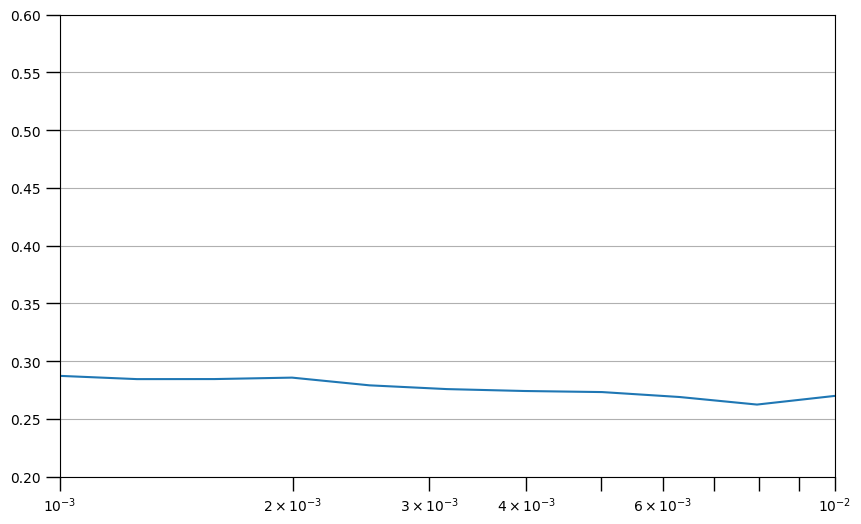

In [160]:
from matplotlib import pyplot as plt
# Define the learning rate array
lrs = init_lr_rate * (10 ** (np.arange(50) / 10))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-3, 1e-2, 0.2, 0.6])

## TRAIN MODEL

In [164]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Set the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0.005,patience = 5,monitor="binary_accuracy")

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,input_shape=[None,num_features]),
  #tf.keras.layers.Conv1D(32,1,padding="same",input_shape=[None,num_features]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True,dropout=0.2)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.2,)),

  tf.keras.layers.Dense(2,activation ='softmax'),
  #tf.keras.layers.Dense(num_classes,activation ='sigmoid')   
])

# Set the learning rate
learning_rate = 0.0158
epochs = 30

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(
    #loss=tf.keras.losses.Huber(), optimizer=optimizer)
    optimizer = optimizer,
    loss = "binary_crossentropy",
    metrics=['binary_accuracy'])
    # loss=tf.keras.losses.CategoricalCrossentropy(),
    # metrics=['categorical_accuracy'])

# Train the model
history = model.fit(dataset,epochs=epochs,callbacks =[early_stopping])

Epoch 1/30
10325/10325 [==============================] - 193s 18ms/step - loss: 0.3006 - binary_accuracy: 0.8809
Epoch 2/30
10325/10325 [==============================] - 193s 19ms/step - loss: 0.3030 - binary_accuracy: 0.8805
Epoch 3/30
10325/10325 [==============================] - 206s 20ms/step - loss: 0.3095 - binary_accuracy: 0.8774
Epoch 4/30
10325/10325 [==============================] - 207s 20ms/step - loss: 0.3132 - binary_accuracy: 0.8764
Epoch 5/30
10325/10325 [==============================] - 207s 20ms/step - loss: 0.3177 - binary_accuracy: 0.8750
Epoch 6/30
10325/10325 [==============================] - 221s 21ms/step - loss: 0.3156 - binary_accuracy: 0.8757


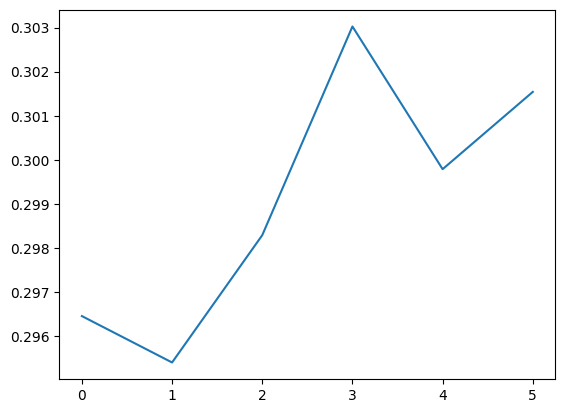

In [162]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"])

In [165]:
model_name = f"lstm_1x32_lr_{learning_rate}"
model_name
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "model/weights/cp-{model_name}_v2-{epoch:04d}_{now}.ckpt"
# save weights 
model.save_weights(checkpoint_path.format(epoch=epochs,now=now,model_name=model_name))
#save model
models_path = "model/saved_models/{model_name}_{version}_{now}"
model.save(models_path.format(version = "v2", now = now,model_name=model_name))

INFO:tensorflow:Assets written to: model/saved_models/lstm_1x32_lr_0.0158_v2_2023-12-03\assets


INFO:tensorflow:Assets written to: model/saved_models/lstm_1x32_lr_0.0158_v2_2023-12-03\assets


In [125]:

from dataloader.dataloader import Serie
importlib.reload(dataloader.dataloader)
try: 
    del Serie
except:
    pass
from dataloader.dataloader import Serie

def predict(model,serie):
    def _transform(x):
    #return (x-self.mean)/(self.__class__.epsilon+self.std)
        epsilon = 1e-15
        std = ds.std
        return (x)/(epsilon+np.abs(std))
    # x = serie.get_correct_slices()[:,:150,:]
    x = serie.get_correct_slices()
    x = _transform(x)
    x = Dataset.windowed_trainset(x, window_size, batch_size)
    y_pred = None

    try:
        y_pred = model.predict(x)
        y_pred = y_pred.reshape(1,-1, y_pred.shape[-1])
        # y_pred = int(y_pred >0.5)
        print(y_pred.shape)
        print(y_pred)
    except ValueError:
        print(x.shape)


    
    #print(y_pred)
    serie_events  = Serie.create_events(serie,y_pred,only_top_score=True)  
    #return serie_events, raw_prediction
    return serie_events, y_pred

In [126]:
raw_predictions = {}
series_pred = np.array([])
y_pred = None
pred_start = False
for serie_id, serie in test_series.series.items():
    #serie_events, raw_predictions[serie_id] = predict(unet,serie)
    serie_events, y = predict(model,serie)
    print(serie_id)
    #print(serie_events)
    if pred_start == False:
        series_pred = y
        y_pred = serie_events
        pred_start = True
    else:
        series_pred = np.concatenate((series_pred, y))
        y_pred = pd.concat([y_pred, serie_events])
y_pred

(150, 5)
<_TensorSliceDataset element_spec=TensorSpec(shape=(5,), dtype=tf.float64, name=None)>
1/1 [==============================] - 1s 625ms/step
(1, 150, 2)
[[[0.77076155 0.2292385 ]
  [0.7003004  0.29969957]
  [0.6568088  0.34319124]
  [0.63618433 0.36381567]
  [0.6342797  0.36572024]
  [0.6466819  0.35331813]
  [0.6654027  0.33459732]
  [0.69002414 0.3099759 ]
  [0.72178805 0.2782119 ]
  [0.74238473 0.2576153 ]
  [0.75504196 0.24495803]
  [0.799413   0.20058697]
  [0.8493264  0.15067358]
  [0.84410226 0.1558977 ]
  [0.8587254  0.14127457]
  [0.8858265  0.11417345]
  [0.87972903 0.12027093]
  [0.967282   0.03271803]
  [0.97083986 0.0291601 ]
  [0.976115   0.02388509]
  [0.9839193  0.01608066]
  [0.99248874 0.00751125]
  [0.9912894  0.00871061]
  [0.9967713  0.00322873]
  [0.99758124 0.00241867]
  [0.99775034 0.00224962]
  [0.9977997  0.00220025]
  [0.9976659  0.00233415]
  [0.9975623  0.00243772]
  [0.9967248  0.00327519]
  [0.66898525 0.33101475]
  [0.21215023 0.7878497 ]
  [0.22

,series_id,step,event,score
0,038441c925bb,31,onset,0.6
0,03d92c9f6f8a,30,onset,0.7


In [40]:
fig,ax = plt.subplot(series_pred[0])
for i in range(series_pred[0]):
    ax[i].plot(np.argmax(series_pred[i:i+1,:,-1],axis = 0,keepdims=True))

plt.show()

ValueError: Single argument to subplot must be a three-digit integer, not array([[0.16111296, 0.83888704],
       [0.15318179, 0.8468182 ],
       [0.16249315, 0.8375069 ],
       [0.15979289, 0.84020716],
       [0.14409688, 0.8559031 ],
       [0.12899503, 0.871005  ],
       [0.11784398, 0.8821561 ],
       [0.11010622, 0.88989383],
       [0.10593943, 0.89406055],
       [0.10453817, 0.89546186],
       [0.10481721, 0.89518285],
       [0.10668804, 0.89331204],
       [0.11295351, 0.8870465 ],
       [0.1171293 , 0.8828707 ],
       [0.1175453 , 0.8824547 ],
       [0.11683851, 0.8831615 ],
       [0.1162599 , 0.8837401 ],
       [0.1089466 , 0.8910534 ],
       [0.2625289 , 0.73747104],
       [0.2945213 , 0.7054786 ],
       [0.29877022, 0.70122975],
       [0.29662302, 0.70337695],
       [0.29263535, 0.7073646 ],
       [0.29659232, 0.7034077 ],
       [0.3049659 , 0.69503415],
       [0.32025272, 0.6797473 ],
       [0.2765584 , 0.7234416 ],
       [0.06744166, 0.9325584 ],
       [0.06157621, 0.9384238 ],
       [0.06298145, 0.9370186 ],
       [0.06397939, 0.93602055],
       [0.06416202, 0.9358379 ],
       [0.06425798, 0.935742  ],
       [0.06433515, 0.9356649 ],
       [0.06440175, 0.9355983 ],
       [0.06445984, 0.9355402 ],
       [0.06451901, 0.935481  ],
       [0.06456679, 0.93543327],
       [0.0646204 , 0.9353796 ],
       [0.06467292, 0.93532705],
       [0.06472059, 0.9352794 ],
       [0.06477184, 0.9352282 ],
       [0.06482148, 0.93517846],
       [0.06487051, 0.93512946],
       [0.06491503, 0.935085  ],
       [0.06496692, 0.9350331 ],
       [0.06501142, 0.93498856],
       [0.06505875, 0.93494123],
       [0.06510492, 0.9348951 ],
       [0.06515107, 0.93484896],
       [0.06519862, 0.93480146],
       [0.06524401, 0.93475604],
       [0.06529215, 0.9347078 ],
       [0.06533806, 0.934662  ],
       [0.06538486, 0.93461514],
       [0.06543208, 0.9345679 ],
       [0.06547482, 0.93452513],
       [0.06552003, 0.93447995],
       [0.06556533, 0.9344347 ],
       [0.06560887, 0.9343912 ],
       [0.06565308, 0.934347  ],
       [0.06569724, 0.93430275],
       [0.06574224, 0.93425775],
       [0.06578355, 0.93421644],
       [0.06582314, 0.9341768 ],
       [0.06586355, 0.93413645],
       [0.06590778, 0.9340922 ],
       [0.06593855, 0.93406147],
       [0.06597988, 0.9340201 ],
       [0.06603611, 0.9339639 ],
       [0.06607208, 0.93392795],
       [0.06610353, 0.9338964 ],
       [0.06614312, 0.9338569 ],
       [0.06615333, 0.93384665],
       [0.06619628, 0.9338037 ],
       [0.06624639, 0.9337536 ],
       [0.06628174, 0.93371826],
       [0.06633008, 0.9336699 ],
       [0.06636677, 0.93363327],
       [0.06640177, 0.9335982 ],
       [0.06643552, 0.9335645 ],
       [0.06646812, 0.9335319 ],
       [0.06649483, 0.9335052 ],
       [0.06652135, 0.93347865],
       [0.06656231, 0.93343765],
       [0.066595  , 0.93340504],
       [0.06662469, 0.9333753 ],
       [0.06665581, 0.9333442 ],
       [0.06668691, 0.93331313],
       [0.06671734, 0.9332827 ],
       [0.0667456 , 0.9332544 ],
       [0.06677262, 0.93322736],
       [0.06679515, 0.9332048 ],
       [0.06683199, 0.933168  ],
       [0.06686001, 0.93314004],
       [0.06688368, 0.93311626],
       [0.06691366, 0.9330863 ],
       [0.06692475, 0.93307525],
       [0.06695604, 0.93304396],
       [0.06698959, 0.9330104 ],
       [0.06700677, 0.9329932 ],
       [0.0670308 , 0.9329692 ],
       [0.06704871, 0.9329513 ],
       [0.06707959, 0.93292046],
       [0.06710563, 0.9328944 ],
       [0.06714106, 0.93285894],
       [0.06715333, 0.93284667],
       [0.06718384, 0.9328162 ],
       [0.06719848, 0.93280154],
       [0.0672351 , 0.9327648 ],
       [0.06726477, 0.9327352 ],
       [0.0672727 , 0.9327273 ],
       [0.06729009, 0.9327099 ],
       [0.06731251, 0.93268746],
       [0.0673326 , 0.9326674 ],
       [0.06737905, 0.9326209 ],
       [0.0673788 , 0.93262124],
       [0.06740759, 0.9325924 ],
       [0.06742848, 0.93257153],
       [0.06745584, 0.9325442 ],
       [0.06748913, 0.9325109 ],
       [0.06748762, 0.93251234],
       [0.06750625, 0.9324937 ],
       [0.06753122, 0.9324687 ],
       [0.06755175, 0.9324482 ],
       [0.06757353, 0.93242645],
       [0.06760025, 0.9323997 ],
       [0.06761866, 0.93238133],
       [0.06763835, 0.93236166],
       [0.06766021, 0.9323398 ],
       [0.06768548, 0.9323145 ],
       [0.0677192 , 0.93228084],
       [0.06775304, 0.932247  ],
       [0.06778558, 0.93221444],
       [0.06784915, 0.93215084],
       [0.06790342, 0.93209654],
       [0.06796851, 0.9320315 ],
       [0.06809137, 0.9319086 ],
       [0.06825279, 0.93174726],
       [0.0684841 , 0.9315159 ],
       [0.06881908, 0.93118095],
       [0.06930964, 0.93069035],
       [0.06999747, 0.9300025 ],
       [0.0709026 , 0.9290974 ],
       [0.07209802, 0.927902  ],
       [0.0735753 , 0.9264247 ],
       [0.0751138 , 0.9248862 ],
       [0.07640202, 0.92359793],
       [0.07735088, 0.92264915],
       [0.07833275, 0.9216673 ]], dtype=float32)

<Figure size 640x480 with 0 Axes>

In [47]:
ds.std

array([3.75824896e+01, 1.18044331e-01, 2.19263949e+00, 1.55956377e-02])